In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from fastai.text import *

path = "/content/drive/My Drive/DATA-475/imdb"

In [3]:
# create TextLMDataBunch using the csv in path
#     remember to specify the text column
data_lm = TextLMDataBunch.from_csv(
    path,
    "train.csv",
    text_cols="review"
)

In [4]:
# create TextClasDataBunch using the csv in path
#     remember to specify the text/label column
#     specify test dataset, vocab, and bs
data_clas = TextClasDataBunch.from_csv(
    path,
    "train.csv",
    test="test.csv",
    text_cols="review",
    label_cols="sentiment",
    vocab=data_lm.train_ds.vocab,
    bs=32
)

In [5]:
# create language model learner with AWD_LSTM architecture and drop_mult of 0.5
lm_learner = language_model_learner(data_lm,arch=AWD_LSTM,drop_mult=0.5)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06
Min loss divided by 10: 5.75E-03


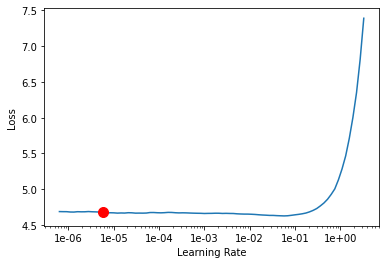

In [6]:
# find a learing rate
lm_learner.lr_find()
lm_learner.recorder.plot(suggestion=True)

In [7]:
# fit one cycle
lr = lm_learner.recorder.min_grad_lr
lm_learner.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.668821,4.465458,0.263642,04:21
1,4.668672,4.455417,0.264222,04:21


In [8]:
# save the encoder
lm_learner.save_encoder("model")

In [9]:
lm_learner.predict("this movie talks about Canadian", n_words=20)

'this movie talks about Canadian men in the context of their diplomatic roles and their relationship , which it attributes to their studies being held'

In [10]:
clas_learner = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
clas_learner.load_encoder("model")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (19999 items)
x: TextList
xxbos i mistakenly kept myself awake late last night watching this thing . xxmaj about the only thing i could say good about this horrid film is that it could be used by film schools to show how not to make a movie . xxmaj no proper character development , wait , i 'm not even sure they were characters . xxmaj set - ups were hokey and inane , and the overuse of split screens was wasted since sometimes they could n't even synchronize with alternate shots . xxmaj if i could give this a zero or minus rating i would . xxmaj sadly , it is n't even worth the time for a few laughs . xxmaj it 's just a sad example of money wasted by xxmaj hollywood , and now i waste my time even thinking about it .,xxbos i watched this film without knowing anything about it whatsoever and found it similar thematically to xxmaj billy xxmaj elliott ( 2000 ) . xxmaj both films are based around a troubled father / son relationship . xxm

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03
Min loss divided by 10: 1.74E-02


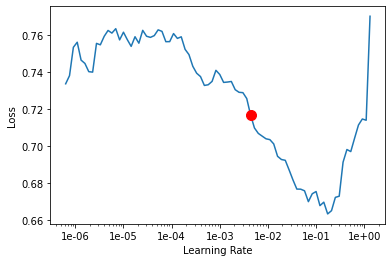

In [11]:
# tune the text_classifier_learner to accpetable accuracy (>80%)
clas_learner.lr_find()
clas_learner.recorder.plot(suggestion=True)

In [12]:
lr = clas_learner.recorder.min_grad_lr
clas_learner.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.493652,0.421263,0.807438,01:40
1,0.463819,0.384241,0.834433,01:36
2,0.429202,0.365563,0.840032,01:37
3,0.431459,0.361840,0.843431,01:36


In [13]:
clas_learner.predict("This is a horrible movie.")

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


(Category tensor(1), tensor(1), tensor([0.2418, 0.7582]))

In [14]:
clas_learner.predict("This is a great movie,")

(Category tensor(1), tensor(1), tensor([4.0065e-04, 9.9960e-01]))

In [15]:
# Check the label mapping
# suppose it returns {'negative': 0, 'positive': 1}
data_clas.train_ds.y.c2i

{'negative': 0, 'positive': 1}

In [16]:
import pandas as pd


df = pd.read_csv(path+"/test.csv")
y_true = tensor(df["sentiment"]=="positive")

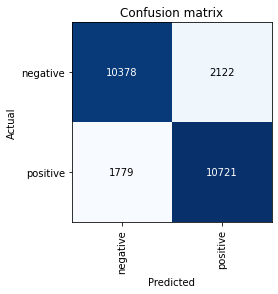

In [17]:
interp = TextClassificationInterpretation.from_learner(
    clas_learner, 
    ds_type=DatasetType.Test
)
interp.y_true = tensor(df["sentiment"]=="positive")
interp.plot_confusion_matrix()

In [18]:
from fastai.metrics import accuracy

accuracy(interp.preds, interp.y_true)

tensor(0.8440)